# Indian States COVID-19 inactivity rate

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/129HbykfqeHMZ6iMx__C2hgyEH0JNadUO">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/bankarpranit26/deep-learning/blob/master/learnings/COVID19_IndiaStates.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

## Import the libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

## Get data for the states

In [0]:
ROOT_URL = 'https://api.covid19india.org/states_daily_csv/'
states_confirmed = pd.read_csv(ROOT_URL + 'confirmed.csv')
states_deceased = pd.read_csv(ROOT_URL + 'deceased.csv')
states_recovered = pd.read_csv(ROOT_URL + 'recovered.csv')

## Preprocess the data

In [0]:
# Remove NaNs
states_confirmed.fillna(0, inplace=True)
states_deceased.fillna(0, inplace=True)
states_recovered.fillna(0, inplace=True)

In [0]:
# Remove the rows for current and future dates (if any)
current_date = date.today()
start_date = date(2020, 4, 1)
states_confirmed['date'] = pd.to_datetime(states_confirmed['date'])
states_confirmed.drop(states_confirmed[states_confirmed['date'] >= np.datetime64(current_date)].index, inplace=True)

# Save the start and end index
start_index = states_confirmed[states_confirmed['date'] == np.datetime64(start_date)].index[0]
end_index = states_confirmed.index[-1]

In [0]:
# Merge the recovered and deceased data
# Ignore the columns: date, total and unnamed
# Cumulate the data
states_inactive = states_recovered.iloc[:, 2:-1].add(states_deceased.iloc[:, 2:-1], fill_value=0).cumsum()
del states_recovered, states_deceased

# Ignore the columns: date, total and unnamed
# Cumulate the data
states_confirmed = states_confirmed.iloc[:, 2:-1].cumsum()

In [0]:
states_confirmed = states_confirmed.astype('int32')
states_inactive = states_inactive.astype('int32')

## Create a class to perform data analysis

In [0]:
class Inactivity:
    def __init__(self, C, I):
        self.C = np.array(C)
        record_start = np.where(self.C != 0)
        # More than 0 cases
        if len(record_start[0]) > 0:
            self.start_index_adjustment = record_start[0][0]
        else:
            self.start_index_adjustment = len(self.C)
        self.C = self.C[record_start]
        self.I = list(np.array(I)[record_start])
        self.intervals = {i: (i1, i2) for i, (i1,i2) in enumerate(zip(self.C[:-1], self.C[1:]))}

    def find_first_range(self, value):
        b = self.C - value
        indices = np.squeeze(np.argwhere(b[:-1] * b[1:]<=0))
        if len(indices.shape) == 0:
            indices = [int(indices)]
        elif len(indices) == 0:
            return -1, None
        return indices[0], self.intervals[indices[0]]

    def get_interpolated_index(self, value):
        index, interval = self.find_first_range(value)
        if index >= 0:
            if interval[0] == interval[1]:
                return 0
            else:
                return index + abs((value-interval[0])/(interval[1]-interval[0]))
        else:
            return 0
    
    def get_inactivity_rate(self, start_idx=0, precision=2):
        rates = []
        for idx, value in enumerate(self.I):
            if idx >= (start_idx - self.start_index_adjustment):
                rates.append(round(idx - self.get_interpolated_index(value), precision))
        return rates

## Run the inactivity analysis for all states

In [0]:
# Get the total duration
total_duration = end_index - start_index + 1
inactivity_rates = {}
for state in states_confirmed.columns:
    obj = Inactivity(states_confirmed.loc[:, state], states_inactive.loc[:, state])
    rates = obj.get_inactivity_rate(start_index)
    # pre-pad the rates to match the sequence
    inactivity_rates[state] = [0] * (total_duration - len(rates)) + rates

In [0]:
# print(inactivity_rates)

## Run and plot the inactivity analysis for relevant states

In [0]:
# Define a function to return the relevant state information
def get_states():
    # Looking at the top 5 states with highest confirmed cases
    return states_confirmed.iloc[-1,:].sort_values(ascending=False)[:5].index

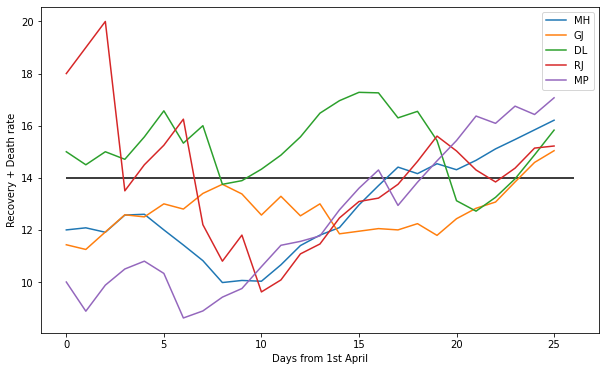

In [104]:
plt.figure(figsize=(10,6))

states = get_states()
for state in states:
    plt.plot(inactivity_rates[state])

plt.legend(states)
plt.hlines(14, 0, total_duration)
plt.xlabel('Days from 1st April')
plt.ylabel('Recovery + Death rate')
plt.show()